**CLASSIFICAZIONE MALATTIE ALBERI DI COCCO** 🌴


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Librerie

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

import numpy as np
import os
import glob

import matplotlib.pyplot as plt

import time

In [ ]:
print(tf.__version__)

2.17.1


# Parametri

In [ ]:

seed_value = 1 # fissare il seme per ottenere riproducibilità dei risultati
tf.random.set_seed(seed_value)

img_width, img_height = 768,1024   # pixel size originale
rescaled_width, rescaled_height= 128,128    # con rescaling

# stampare il formato dell'input
if keras.backend.image_data_format() == 'channels_first':
    ARCHIVE_DATASET = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
    print(f"Input shape: {input_shape}")

n_class = 5 # numero di classi

epochs = 20

batch_size = 10

max_images_per_class = 470 # troncamento di tutte le classi a 470 immagini


Input shape: (768, 1024, 3)


# Preprocessing dataset

## decompressione file .zip

In [ ]:
# ESEGUIRE SOLO 1 VOLTA

%%capture
zip_path = '/content/drive/MyDrive/Colab Notebooks/tesina_Embedded/Coconut_dataset/'
extract_path = 'Coconut_Tree_Disease_Dataset'
!unzip -q "$zip_path"$extract_path".zip" -d "$zip_path" #quiet mode: riduce output

In [ ]:
# visualizzo un'immagine
import cv2
from google.colab.patches import cv2_imshow

img_path="/content/drive/MyDrive/Colab Notebooks/tesina_Embedded/Coconut_dataset/Coconut Tree Disease Dataset/Stem Bleeding/StemBleeding001.jpg";
img = cv2.imread(img_path)
cv2_imshow(img)

Output hidden; open in https://colab.research.google.com to view.

## troncamento dataset

Prima di splittare tronco a 470 le immagini di ogni classe per avere un dataset bilanciato

In [ ]:
# Percorso della cartella che contiene tutte le immagini delle classi
dataset_dir = '/content/drive/MyDrive/Colab Notebooks/tesina_Embedded/Coconut_dataset/Coconut Tree Disease Dataset'
# Percorso cartella in cui mettere le immagini troncate
output_dir = '/content/drive/MyDrive/Colab Notebooks/tesina_Embedded/Coconut_dataset/Dataset_troncato'

In [ ]:
# Crea la cartella di output se non esiste
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
# ESEGUIRE SOLO 1 VOLTA

import random
import shutil

# Tronca le immagini di ciascuna classe a 470, senza caricarle in memoria
for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)

    # Controlla se è una directory valida (per evitare file non necessari)
    if not os.path.isdir(class_dir):
        continue

    # Crea la cartella corrispondente nella cartella di output
    output_class_dir = os.path.join(output_dir, class_name)
    if not os.path.exists(output_class_dir):
        os.makedirs(output_class_dir)

    # Prendi tutte le immagini dalla classe corrente
    images = os.listdir(class_dir)

    # Seleziona casualmente 470 immagini senza caricare tutto in memoria
    selected_images = random.sample(images, min(max_images_per_class, len(images)))

    # Copia le immagini selezionate nella nuova cartella di output, una alla volta
    for image in selected_images:
        source_image_path = os.path.join(class_dir, image)
        destination_image_path = os.path.join(output_class_dir, image)
        shutil.copyfile(source_image_path, destination_image_path)  # Copia senza caricare in memoria

print("Troncamento completato. 470 immagini per ciascuna classe sono state salvate in", output_dir)

CONTA IMMAGINI PER VERIFICARE CHE IL TRONCAMENTO SIA AVVENUTO CORRETTAMENTE

In [ ]:
# Percorso della cartella del dataset
dataset_dir = '/content/drive/MyDrive/Colab Notebooks/tesina_Embedded/Coconut_dataset/Dataset_troncato'

# Itera attraverso ciascuna classe (cartella) e conta le immagini
for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)

    # Verifica che sia una directory valida (non un file)
    if os.path.isdir(class_dir):
        # Conta il numero di immagini (file) nella cartella della classe
        num_images = len(os.listdir(class_dir))
        print(f"Classe {class_name}: {num_images} immagini")

Classe Leaf Rot: 470 immagini
Classe Stem Bleeding: 470 immagini
Classe Bud Root Dropping: 470 immagini
Classe Bud Rot: 470 immagini
Classe Gray Leaf Spot: 470 immagini


## suddivisione dataset

In [ ]:
# libreria utile per suddividere dataset in 3 subset: train-validation-test

!pip install split-folders
import splitfolders

In [ ]:
input_folder= '/content/drive/MyDrive/Colab Notebooks/tesina_Embedded/Coconut_dataset/Dataset_troncato'
output_folder= '/content/drive/MyDrive/Colab Notebooks/tesina_Embedded/Coconut_dataset/Dataset_splittato'

In [ ]:
# suddivisione dataset: 80% training, 10% validation, 10% test
splitfolders.ratio(input_folder, output= output_folder, seed=1337, ratio=(.8,.1,.1))
print("\n\nDataset suddiviso in training, validation e test set")

In [ ]:
train_data_dir="/content/drive/MyDrive/Colab Notebooks/tesina_Embedded/Coconut_dataset/Dataset_splittato/train"
val_data_dir="/content/drive/MyDrive/Colab Notebooks/tesina_Embedded/Coconut_dataset/Dataset_splittato/val"
test_data_dir="/content/drive/MyDrive/Colab Notebooks/tesina_Embedded/Coconut_dataset/Dataset_splittato/test"

VERIFICO CHE LO SPLIT SIA AVVENUTO CORRETTAMENTE

In [ ]:
# funzione che conta le immagini
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count

#conto immagini
num_classes=len(glob.glob(train_data_dir+"/*"))
train_samples =get_files(train_data_dir)
test_samples=get_files(test_data_dir)
val_samples=get_files(val_data_dir)

print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")
print(val_samples,"Validation images")

5 Classes
1880 Train images
235 Test images
235 Validation images


## caricamento dati

In [ ]:
# caricamento dati in batch per ridurre l'uso di memoria
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Caricamento del dataset di training
train_dataset = image_dataset_from_directory(train_data_dir,
                                             shuffle=True,
                                             seed=seed_value,
                                             batch_size=batch_size,
                                             image_size=(rescaled_width, rescaled_height), # RESCALING
                                             label_mode='categorical')

# Caricamento del dataset di validazione
validation_dataset = image_dataset_from_directory(val_data_dir,
                                                  shuffle=True,
                                                  seed=seed_value,
                                                  batch_size=batch_size,
                                                  image_size=(rescaled_width, rescaled_height), # RESCALING
                                                  label_mode='categorical')

# Caricamento del dataset di test
test_dataset = image_dataset_from_directory(test_data_dir,
                                            shuffle=True,
                                            seed=seed_value,
                                            batch_size=batch_size,
                                            image_size=(rescaled_width, rescaled_height), # RESCALING
                                            label_mode='categorical')


# Normalizzazione delle immagini di train e val
train_dataset = train_dataset.map(lambda images, labels: ((images/255.0), labels))
validation_dataset = validation_dataset.map(lambda images, labels: ((images/255.0), labels))


Found 1880 files belonging to 5 classes.
Found 235 files belonging to 5 classes.
Found 235 files belonging to 5 classes.


## ottimizzazione

In [ ]:
# configurare la cache e il prefetching per ottimizzare le prestazioni di caricamento dei dati
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)


# Modello

## **Struttura del modello**

In [ ]:
model = Sequential() ## modello utilizzato

# Primo blocco convoluzionale
model.add(Conv2D(8, (3, 3), input_shape=(rescaled_width, rescaled_height, 3), name='Conv2D_1'))
model.add(Activation('relu', name='ReLU_1'))
model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPool_1'))

# Secondo blocco convoluzionale
model.add(Conv2D(16, (3, 3), name='Conv2D_2'))
model.add(Activation('relu', name='ReLU_2'))
model.add(MaxPooling2D(pool_size=(2,2), name='MaxPool_2'))

# Terzo blocco convoluzionale
model.add(Conv2D(16, (3, 3), name='Conv2D_3'))
model.add(Activation('relu', name='ReLU_3'))
model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPool_3'))

model.add(Dropout(0.6,  name='Dropout')) # Dropout per prevenire overfitting
model.add(Flatten(name='Flatten')) # Flatten per appiattire l'output dei livelli convoluzionali

# Livello finale di uscita per la classificazione
model.add(Dense(5, name='Dense_2'))	# 5 CLASSI
model.add(Activation('softmax', name='Softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv2D_1 (Conv2D)                    │ (None, 126, 126, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_1 (Activation)                  │ (None, 126, 126, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_1 (MaxPooling2D)             │ (None, 63, 63, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_2 (Conv2D)                    │ (None, 61, 61, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_2 (Activation)                  │ (None, 61, 61, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_2 (MaxPooling2D)             │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_3 (Conv2D)                    │ (None, 28, 28, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_3 (Activation)                  │ (None, 28, 28, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_3 (MaxPooling2D)             │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout (Dropout)                    │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2 (Dense)                      │ (None, 5)                   │          15,685 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Softmax (Activation)                 │ (None, 5)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,397 (75.77 KB)

 Trainable params: 19,397 (75.77 KB)

 Non-trainable params: 0 (0.00 B)

### Visualizzo il modello

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 51.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


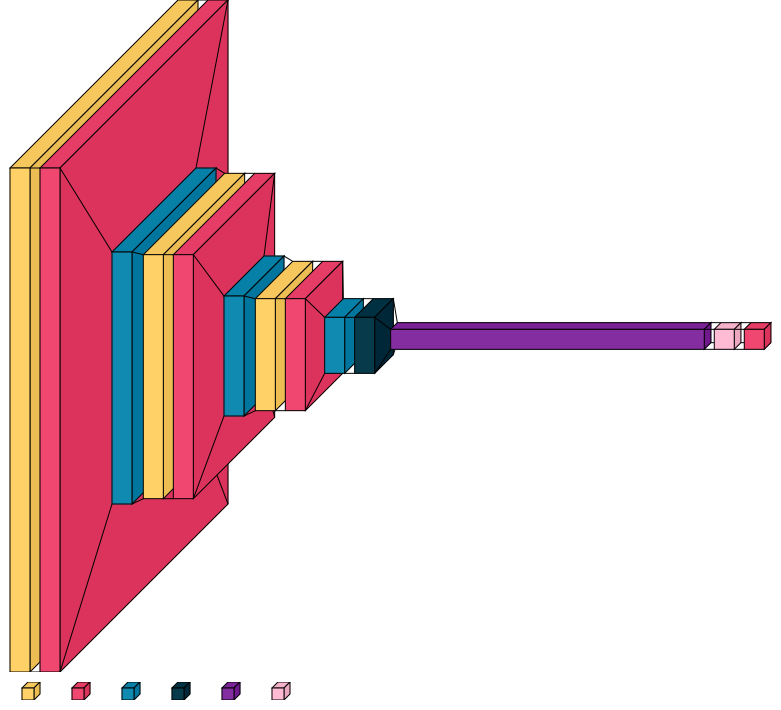

In [ ]:
# !pip install visualkeras
# c'è un warning riguardo un futuro aggiornamento quindi carico la versione aggiornata di visualkeras:

!pip install -q --upgrade visualkeras matplotlib
import visualkeras

visualkeras.layered_view(model, legend=True)

## **Addestramento del modello**

In [ ]:
# COMPILAZIONE
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(learning_rate=1.0, name='Adadelta'),
              metrics=['accuracy'])

# Le etichette sono già nel formato one-hot encoded,
# quindi la funzione di perdita corretta da utilizzare è categorical_crossentropy

In [ ]:
# definizione dei callbacks
early_stopping= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)

model_checkpoint= tf.keras.callbacks.ModelCheckpoint('best_model.h5.keras',save_best_only=True,
                                                     monitor='val_loss', mode='min')
# per salvare il miglior modello e interrompere
# il training quando non ci sono miglioramenti

In [ ]:
# TRAINING
start = time.time()

#with tf.device('/device:GPU:0'):

history = model.fit(

      train_dataset,

      epochs=epochs,
      batch_size = batch_size,
      validation_data=validation_dataset,


      callbacks=[early_stopping, model_checkpoint],

      verbose=True)



print ('Time taken for training: {} sec\n'.format(time.time() - start))

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 369s 2s/step - accuracy: 0.3311 - loss: 1.4970 - val_accuracy: 0.7106 - val_loss: 0.7434
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 33s 177ms/step - accuracy: 0.7001 - loss: 0.7952 - val_accuracy: 0.7234 - val_loss: 0.6383
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 33s 177ms/step - accuracy: 0.7657 - loss: 0.5785 - val_accuracy: 0.8255 - val_loss: 0.4451
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 182ms/step - accuracy: 0.8216 - loss: 0.4489 - val_accuracy: 0.8255 - val_loss: 0.4168
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 40s 177ms/step - accuracy: 0.8461 - loss: 0.3990 - val_accuracy: 0.8894 - val_loss: 0.3111
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 33s 176ms/step - accuracy: 0.8711 - loss: 0.3368 - val_accuracy: 0.8766 - val_loss: 0.2862
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 44s 194ms/step - accuracy: 0.8816 - loss: 0.3152 - val_accuracy: 0.8723 - val_loss: 0.2808
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 40s 190ms/step - accuracy: 0.9024 - loss: 0.2

## Salvataggio del modello

In [ ]:
MODELS_PATH = '/content/drive/My Drive/Colab Notebooks/tesina_Embedded/models/'

name_modelTF = os.path.join(MODELS_PATH, 'CNN_coconut_model.h5') # salvataggio del modello in file .h5.
name_modelTFLite = os.path.join(MODELS_PATH, 'CNN_coconut_model.tflite')

model.save(name_modelTF)

In [ ]:
## RISOLVERE PROBLEMA CON STM32CubeIDE ##

# Carica il modello
model = load_model(name_modelTF)

# Stampo la configurazione del primo layer per vedere se c'è il campo 'batch_shape' che dà problemi
input_layer = model.layers[0]
print(input_layer.get_config())

{'name': 'Conv2D_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 8, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}


### Valutazione del modello

Plot dei progressi di training e validation

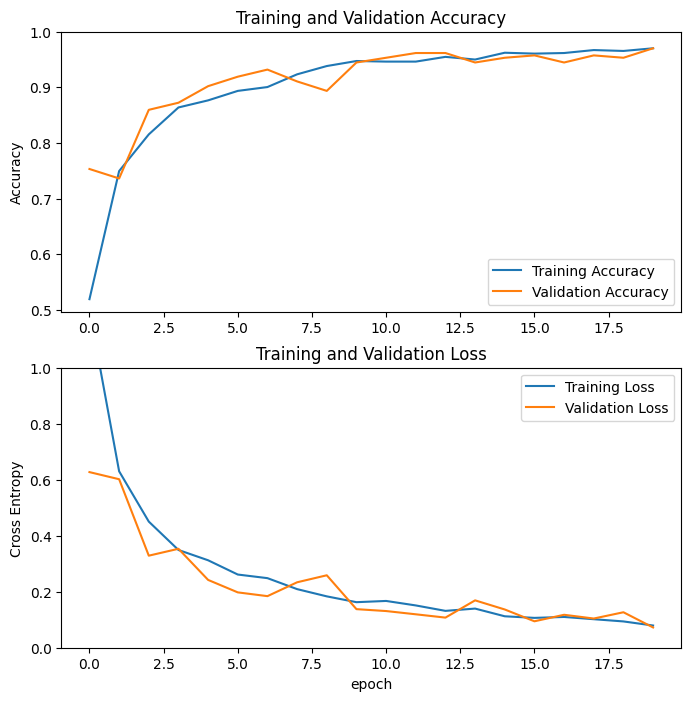

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### **Stima dimensioni del modello**

In [ ]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' KB')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' MB')
    else:
        return print('File size: ' + str(size) + ' bytes')


# Calcolo dimensioni
convert_bytes(get_file_size(name_modelTF), "MB")
convert_bytes(get_file_size(name_modelTF), "KB")
get_file_size(name_modelTF)

File size: 0.268 MB
File size: 274.359 KB


280944

# Matrice di confusione

In [ ]:
# **************          matrix_confusion         ***************

# Mette a confronto due liste:  una contenente le labels originali delle immagini di test,
#                               l'altra contenente le labels predette dalla CNN.

# Parameters:
#                - original :           lista contenente le labels originali delle immagini
#                - model:               lista contenente le labels predette
#                - n_class :            numero di classi
#                - nb_test_samples :    numero di immagini di test

# Return:
#               - confusion_matrix :    matrice di confusione.

def matrix_confusion (original , model, n_class, nb_test_samples):

    # creo una matrice di zeri, di dimensioni corrispondenti al numero di classi
    confusion_matrix = np.zeros((n_class,n_class))


    # confronto le due liste contenenti le label vere e quelle predette.
    l = len(original)
    k=0
    while k<l:
        confusion_matrix[original[k]][model[k]] += 1
        k+=1

    print('matrice di confusione \n', confusion_matrix)
    print('\n')

    # calcolo l'accuratezza delle predizioni

    correct_predictions = sum(confusion_matrix[i][i] for i in range(n_class))

    total_prediction = nb_test_samples

    accuracy = correct_predictions/total_prediction

    print('ACCURACY... : ' , round(accuracy*100, 2), '%')
    print('\n')
    return confusion_matrix

# Conversione modello in TFLite

In [ ]:
start = time.time()

input_ds = image_dataset_from_directory(train_data_dir,
                                        shuffle=True,
                                        seed=seed_value,
                                        batch_size=1,
                                        image_size=(rescaled_width, rescaled_height),
                                        label_mode=None)



print("1. ", input_ds)

# preprocessing images if needed
input_ds = input_ds.map(lambda images: (images/255.0))

def representative_dataset_gen():
	for input_value in input_ds.take(100):
		yield [input_value]


print ('Time taken for load training set: (tflite): {} sec\n'.format(time.time() - start))

Found 1880 files.
1.  <_PrefetchDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>
Time taken for load training set: (tflite): 1.2707304954528809 sec



In [ ]:
# Converter: from keras model

# Carica il modello Keras dal file .h5
model = load_model(name_modelTF)

# Crea il convertitore TensorFlow Lite dal modello Keras caricato
converter = tf.lite.TFLiteConverter.from_keras_model(model)

print("------------------------------converter ok--------------------------------")


# quantizzazione
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen

# Converte il modello quantizzato in formato TensorFlow Lite
tflite_quantized_model = converter.convert()

# senza quantizzazione
#converter.optimizations = []

# Converte il modello in formato TensorFlow Lite
#tflite_model = converter.convert()

# salva il modello convertito in un file .tflite
open(name_modelTFLite, "wb").write(tflite_quantized_model)

print('------------------------quantization and storage ok-----------------------')

------------------------------converter ok--------------------------------
Saved artifact at '/tmp/tmpwk88grqc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  137020933711728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137020933716304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137020933815840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137020933811616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137020934205888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137020934203952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137020696668192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137020696669072: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


------------------------quantization and storage ok-----------------------


In [ ]:
# Compute model size
convert_bytes(get_file_size(name_modelTFLite), "MB")
convert_bytes(get_file_size(name_modelTFLite), "KB")
get_file_size(name_modelTFLite)

File size: 0.024 MB
File size: 24.102 KB


24680

# Test del modello Keras

In [ ]:
# load model
model_loaded = load_model(name_modelTF)

# evaluate
start = time.time()

# loading test images for evaluation

evaluation_dataset = image_dataset_from_directory(test_data_dir,
                                                  shuffle=False,
                                                  batch_size=1,
                                                  image_size=(rescaled_width, rescaled_height),
                                                  label_mode='categorical')

print("1. evaluation_dataset: ", evaluation_dataset)

# preprocessing images
evaluation_dataset = evaluation_dataset.map(lambda images, labels: ((images/255.0), labels))
print("2. evaluation_dataset: ", evaluation_dataset)

# evaluate
evaluate = model_loaded.evaluate(evaluation_dataset)

print("evaluate: ", evaluate)
print('Test loss:', evaluate[0])
print('Test accuracy:', evaluate[1])



print ('Time taken for loading test set {} sec\n'.format(time.time() - start))

Found 235 files belonging to 5 classes.
1. evaluation_dataset:  <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
2. evaluation_dataset:  <_MapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
235/235 ━━━━━━━━━━━━━━━━━━━━ 47s 197ms/step - accuracy: 0.9675 - loss: 0.1008
evaluate:  [0.17662851512432098, 0.9404255151748657]
Test loss: 0.17662851512432098
Test accuracy: 0.9404255151748657
Time taken for loading test set 47.26845407485962 sec



**PREDICTIONS AND MATRIX CONFUSION**

In [ ]:
nb_test_samples = 235

In [ ]:
start = time.time()

# *******************************************************************
# loading test images for predictions and matrix confusion    *******
# *******************************************************************

test_dataset = image_dataset_from_directory(test_data_dir,
                                            shuffle=False,
                                            batch_size=1,
                                            image_size=(rescaled_width, rescaled_height),
                                            label_mode='int')


print("-----------------------------------------------------------------------")
print("1. test_dataset: ", test_dataset)
print("-----------------------------------------------------------------------")


# split images/labels (and preprocessing)
test_images = test_dataset.map(lambda images, labels: (images/255.0))
test_labels = test_dataset.map(lambda images, labels: labels)

print("2. test_images: ", test_images)
print("3. test_labels: ", test_labels)

print("-----------------------------------------------------------------------")


# flatten (no batch)
#test_images = test_images.flat_map(lambda x: tf.data.Dataset.from_tensor_slices(x))
test_labels = test_labels.flat_map(lambda x: tf.data.Dataset.from_tensor_slices(x))

#print("4. test_images flatten: ", test_images)
print("5. test_label flatten: ", test_labels)
print("-----------------------------------------------------------------------")


# convert to list
test_labels_orig = list(test_labels.as_numpy_iterator())

print("labels orig: ", test_labels_orig[:10])



# *******************************************************************
# ***********     prediction and matrix confusion       *************
# *******************************************************************

#prediction -----------------------------------------
predictions = model_loaded.predict(test_images)

print("predictions shape: ", predictions.shape)
print("predictions : ", predictions[0])

# result of predictions
pred_labels = [np.argmax(x) for x in predictions]

print("pred_labels: ", pred_labels)

# matrix confusion  ----------------------------------------
matrix = matrix_confusion (test_labels_orig , pred_labels, n_class, nb_test_samples)



print ('Time taken for loading test set {} sec\n'.format(time.time() - start))

Found 235 files belonging to 5 classes.
-----------------------------------------------------------------------
1. test_dataset:  <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
-----------------------------------------------------------------------
2. test_images:  <_MapDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>
3. test_labels:  <_MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.int32, name=None)>
-----------------------------------------------------------------------
5. test_label flatten:  <_FlatMapDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>
-----------------------------------------------------------------------
labels orig:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
predictions shape:  (235, 5)
predictions :  [7.4869710e-01 2.7601756e-04 2.4527514e-01 5.4488769e-03 

# Test del modello TFLite

**CARICAMENTO ED ELABORAZIONE IMMAGINI DI TEST**

In [ ]:
start = time.time()

# loading test images for TensFlowLite model

test_dataset_TFLite = image_dataset_from_directory(test_data_dir,
                                                   shuffle=False,
                                                   batch_size=1,
                                                   image_size=(rescaled_width, rescaled_height),
                                                   label_mode='int')

print("-----------------------------------------------------------------------")
print("1. test_dataset: ", test_dataset_TFLite)
print("-----------------------------------------------------------------------")

# split images/labels

test_images = test_dataset_TFLite.map(lambda images, labels: tf.dtypes.cast(images-128, tf.int8))
test_labels = test_dataset_TFLite.map(lambda images, labels: labels)

print("2. test_images: ", test_images)
print("3. test_labels ", test_labels)

print("-----------------------------------------------------------------------")



# flatten (no batch)

#test_images = test_images.flat_map(lambda x: tf.data.Dataset.from_tensor_slices(x))
test_labels = test_labels.flat_map(lambda x: tf.data.Dataset.from_tensor_slices(x))

#print("4. test_images flatten: ", test_images)
print("5. test_label flatten: ", test_labels)

print("-----------------------------------------------------------------------")



# list
#test_images = list(test_images.as_numpy_iterator())
test_labels = list(test_labels.as_numpy_iterator())

#print("one hot: ", test_images[0])
#print("one hot: ", test_labels[2210:2230])

print('Time taken for load test set (tflite): {} sec\n'.format(time.time() - start))

Found 235 files belonging to 5 classes.
-----------------------------------------------------------------------
1. test_dataset:  <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
-----------------------------------------------------------------------
2. test_images:  <_MapDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.int8, name=None)>
3. test_labels  <_MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.int32, name=None)>
-----------------------------------------------------------------------
5. test_label flatten:  <_FlatMapDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>
-----------------------------------------------------------------------
Time taken for load test set (tflite): 1.794217586517334 sec



**PREVISIONI**

In [ ]:
start = time.time()

# load model and allocate tensors (allocate working memory for the model)
interpreter = tf.lite.Interpreter(model_path = name_modelTFLite)
interpreter.allocate_tensors()

# get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print(output_details)

# prediction
predictions=list()
i=0
for x in test_images:
	interpreter.set_tensor(input_details[0]['index'], x)
	interpreter.invoke()
	tflite_results = interpreter.get_tensor(output_details[0]['index'])
	predictions.append(np.argmax(tflite_results))
	print("i: ", i)
	i+=1


# Results
matrix = matrix_confusion(test_labels, predictions, n_class, nb_test_samples)

print ('Time taken for test (TFLite): {} sec\n'.format(time.time() - start))

[{'name': 'serving_default_input_layer:0', 'index': 0, 'shape': array([  1, 128, 128,   3], dtype=int32), 'shape_signature': array([ -1, 128, 128,   3], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.003921568859368563, -128), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall_1:0', 'index': 18, 'shape': array([1, 5], dtype=int32), 'shape_signature': array([-1,  5], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
i:  0
i:  1
i:  2
i:  3
i:  4
i:  5
i:  6
i:  7
i:  8
i:  9
i:  10
i:  11
i:  12
i:  13
i:  14
i:  15
i:  16
i:  17
i:  18
i:  19
i:  20
i:  21
i:  22
i:  23
i:  24
i:  25
i:  26
i:  27
i:  28
i:  29
i:  3